In [1]:
import os 
import numpy as np 
import matplotlib.pyplot as plt 
from astropy.io import fits 
from astropy.stats import * 
from photutils.background import Background2D, MedianBackground, MMMBackground
from photutils.detection import DAOStarFinder 
from photutils.aperture import CircularAperture
from photutils.aperture import aperture_photometry

In [2]:
#First define the image in python as a string.
imagefile = "M13_g_align.fit" 
image = fits.open(imagefile)[0].data
header = fits.open(imagefile)[0].header

In [3]:
print(image.shape)

(2042, 3054)


/var/folders/ts/_gjzk30d5ggbnzxtbzmvs2240000gn/T/ipykernel_33099/1794141150.py:2: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(image), #We usually take the log of an image to see the variance of the pixels better.


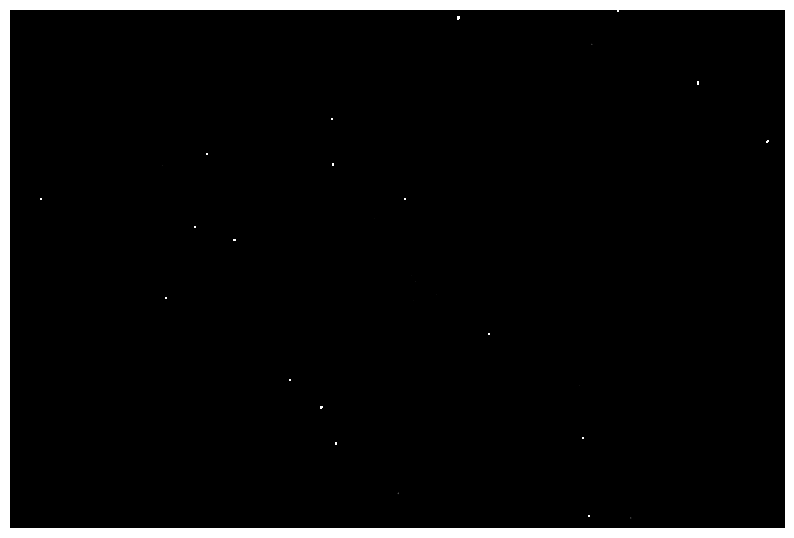

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(np.log(image), #We usually take the log of an image to see the variance of the pixels better.
            origin='lower', #This tells matplotlib where the [0,0] index is. For our images it is in the bottom.
            cmap = "gray", #Use whatever colormap you like, but I find gray the easiest to visualize.
            vmin = 6, vmax = 11) #This defines the data range we want to see. There are ways to automate this but I always do it manually.
plt.axis('off') #This removes the axes, which aren't really relevant for just viewing an image.
plt.show()

In [5]:
mjd = header['MJD-OBS']
print("The Modified Julian Date is", mjd)

The Modified Julian Date is 60067.9566047


In [171]:
sigma_clip = SigmaClip(sigma_lower=3, sigma_upper=3, cenfunc='mean') #doesn't change much for inf sigma
mean, median, std = sigma_clipped_stats(image,sigma_lower=3, sigma_upper=3, cenfunc='mean') 

bkg_estimator = MedianBackground() 
bkg = Background2D(image, 
                    box_size=(10, 10), 
                    filter_size=(9, 9), 
                    sigma_clip=sigma_clip, 
                    bkg_estimator=bkg_estimator) 
bkg_ = bkg.background
bkg_median = bkg.background_median
bkg_rms = bkg.background_rms_median

mmm_bkg = MMMBackground()

daofind = DAOStarFinder(fwhm=1, #smaller <1, more bright stars
                        threshold=std*10,
                        brightest= 200) 
sources = daofind(image - bkg_median) #doesn't change if not subtract bkg
print(sources)

 id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1  2710.263274020231 ...  253.8861083984375   -6.011597346798798
  2 1226.3226838681026 ... 176.42428588867188   -5.616395920547603
  3 2712.0887443977554 ... 136.66946411132812   -5.339178728823585
  4 2983.1762235691112 ...  84.34346008300781   -4.815128533555474
  5 109.53849456594533 ...  51.96317672729492   -4.289239233646932
  6 3031.1986096753103 ...  45.13456344604492   -4.136273115499948
  7 2984.4403124613605 ...  42.48454284667969   -4.070577373512102
...                ... ...                ...                  ...
194 1556.1285087440824 ... 1.2414872646331787 -0.23485567213502842
195 1530.7657553502643 ... 1.2253178358078003  -0.2206218879422615
196 1554.3952656744125 ... 1.2180849313735962 -0.21419392669646425
197 1577.1307939383855 ... 1.2144466638565063  -0.2109461154703129
198 1677.8423687098266 ... 1.2114248275756836 -0.2082411751933

In [168]:
print(mean, median, std, sorted(image_.flatten(),reverse=True)[:10])
print(bkg_median,bkg_rms)
print(np.where(image==image.min()))
print(np.nanstd(image))

34.757893 34.711033 3.5849087 [11981.644, 9622.538, 8471.411, 7548.9663, 7242.5366, 6116.2725, 5300.915, 4932.154, 4762.893, 4011.7263]
34.602386474609375 3.3821142908216597
(array([1752]), array([2711]))
16.197168


/var/folders/ts/_gjzk30d5ggbnzxtbzmvs2240000gn/T/ipykernel_33099/902176125.py:6: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(image), origin='lower', cmap = "gray", vmin=4, vmax = 11)


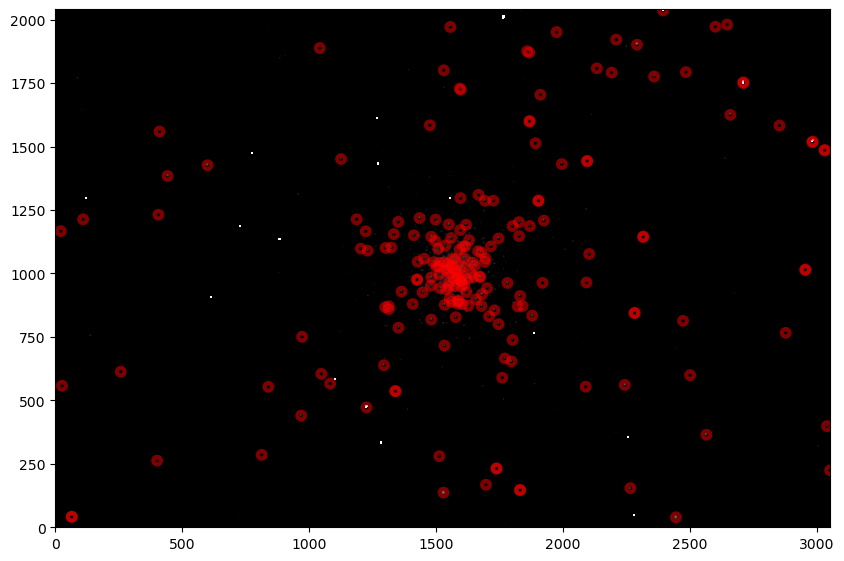

In [172]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid'])) #Positions are transposed by default.
apertures = CircularAperture(positions, r=15) #This defines an 'aperture' by radius around each source. The pixel values inside the aperture are summed to yield the photon count of the star.

#Lets plot our image again with the apertures overplotted to see how many stars we found.
plt.figure(figsize=(10,10))
plt.imshow(np.log(image), origin='lower', cmap = "gray", vmin=4, vmax = 11)
v = apertures.plot(color='red', lw=3, alpha=0.5) 
plt.show()

/var/folders/ts/_gjzk30d5ggbnzxtbzmvs2240000gn/T/ipykernel_33099/564678625.py:3: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(image_), origin='lower', cmap = "gray", vmin=4, vmax = 20)
/var/folders/ts/_gjzk30d5ggbnzxtbzmvs2240000gn/T/ipykernel_33099/564678625.py:3: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(image_), origin='lower', cmap = "gray", vmin=4, vmax = 20)


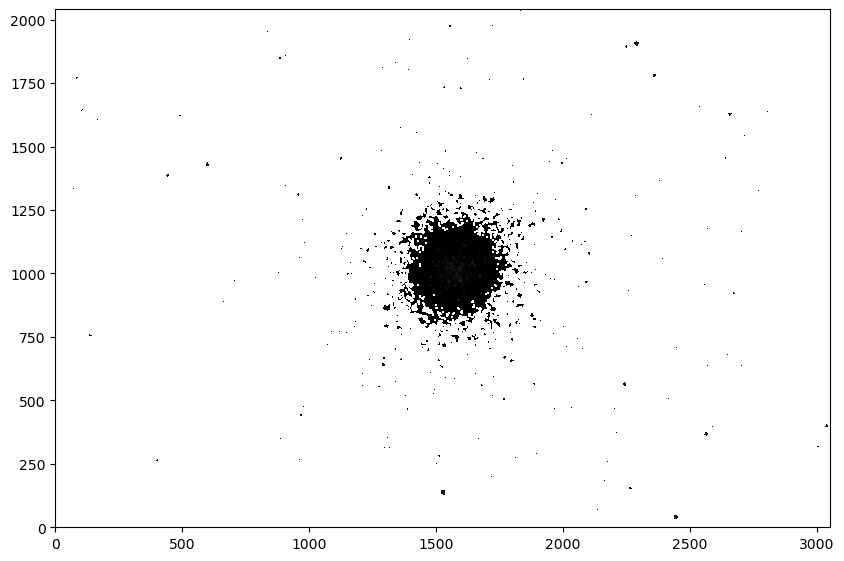

In [160]:
image_ = (image - bkg_median)
plt.figure(figsize=(10,10))
plt.imshow(np.log(image_), origin='lower', cmap = "gray", vmin=4, vmax = 20)
#v = apertures.plot(color='red', lw=3, alpha=0.5) #I define it as a variable to avoid unnecessary readout.
plt.show()